# Patching Final Presentation

### Process (White Background)
- Algo takes in Epithelium extraction
- Repurpose old algorithm to expand squares and use corners to stop expansion
- Attempts 250 times (can be adjusted) to cover as much as possible while maintaining overlap condition
- Returns # Epithelium pixels not covered and the % that is of total epithelium per scan

#### Notes
- White background idea discarded after some attempts to figure out how to solve the coloring issue, proceed to black background algorithm
- Using distinct color for background and stroma makes this process easy and efficient so next quarter if students can perfect that process then I think using 2 colors is easier/better for patching

### Process (Black Background *New*)
- Place squares by checking they have two distinct black regions (regions must be separated by length of 15% of square length)
- Also check that one black region is not more than 70% of total area so it's not focused on one side of patch
- Use 4 box sizes starting at 650x650 and going down by multiples of 130 until 130x130
- For each box size, check that 20-70% of the box covers epithelium (range varies depending on square size, bigger square should have higher % of coverage)

#### Notes
- Works really well on long, skinny tissues
- Works well on normally shaped tissues that are connected or almost connected
- Bad when the maximum width of an epithelium exceeds 650
- Coverage % is very high with Black Background 

## Prashant's code ran separately (displaying one extraction example)

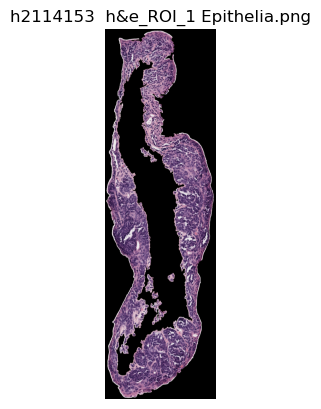

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the file path of the image you want to display
file_path = 'D:\\390scans\\scans\\h2114153  h&e_ROI_1 Epithelia.png' 

# Check if the file exists
if os.path.exists(file_path) and (file_path.endswith('.png') or file_path.endswith('.jpg') or file_path.endswith('.tif')):
    # Load and display the image
    img = mpimg.imread(file_path)
    
    # Check if the image has an alpha channel and remove it if necessary
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:, :, :3]
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(os.path.basename(file_path))  # Show the filename as the title
    plt.show()
else:
    print("The file does not exist or is not a valid image format.")

## Redefine logic from last week

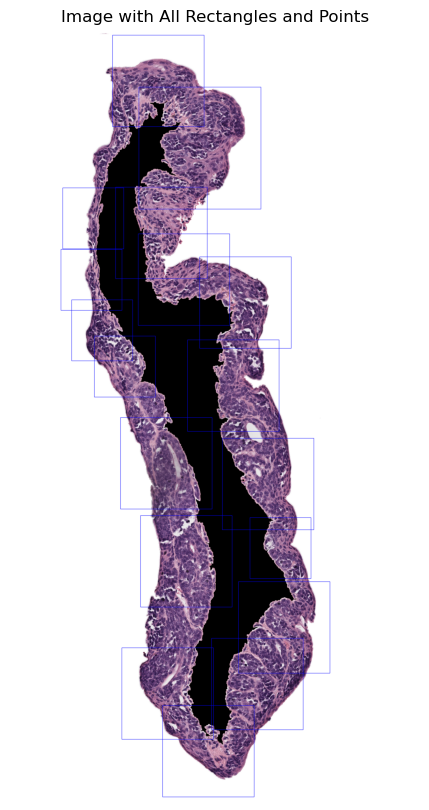

Total squares placed: 18
Coverage of non-black-white mask: 91.39%


In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the image
image_path = 'D:\\390scans\\background_white\\h2114153  h&e_ROI_2 Epithelia_edited.png' 
image = cv2.imread(image_path)

# Function to check if a region contains black, white, and non-black-white mask
def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Create the masks for black, white, and non-black-white pixels
black_mask = cv2.inRange(image, np.array([0, 0, 0]), np.array([0, 0, 0]))
white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))
non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))

# Calculate distance to the nearest black and white pixels
black_distance = cv2.distanceTransform(255 - black_mask, cv2.DIST_L2, 3)
white_distance = cv2.distanceTransform(255 - white_mask, cv2.DIST_L2, 3)

# Find coordinates of non-black and non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Define the ratio tolerance range for balanced points
min_ratio, max_ratio = 0.9, 1.1

# Filter coordinates to only include balanced points
balanced_points = [
    coord for coord in coordinates
    if min_ratio <= (black_distance[coord[0], coord[1]] / white_distance[coord[0], coord[1]]) <= max_ratio
]

# Initialize parameters
max_attempts = 250
initial_size = 128
rectangles = []
coverage_mask = np.zeros_like(non_black_white_mask, dtype=np.uint8)

# Calculate the total non-black-white pixel count
total_non_black_white_pixels = np.sum(non_black_white_mask > 0)

# Function to calculate the overlap ratio
def calculate_overlap_ratio(new_square, coverage_mask, non_black_white_mask):
    top, bottom, left, right = new_square
    square_region = non_black_white_mask[top:bottom, left:right]
    already_covered = coverage_mask[top:bottom, left:right]
    overlap_pixels = np.sum((square_region > 0) & (already_covered > 0))
    total_pixels = np.sum(square_region > 0)
    if total_pixels == 0:
        return 0
    return overlap_pixels / total_pixels

# Start generating squares for the current image
attempts = 0
while len(balanced_points) > 0 and attempts < max_attempts:
    attempts += 1
    random_coord = random.choice(balanced_points)
    center_x, center_y = int(random_coord[1]), int(random_coord[0])
    num_squares_drawn = 0

    # Expansion phase for square
    while True:
        size = initial_size * (num_squares_drawn + 1)
        top, bottom = center_y - size, center_y + size
        left, right = center_x - size, center_x + size

        # Define regions at each corner of the square
        corner_checks = {
            "top_left": (top, left),
            "top_right": (top, right - initial_size),
            "bottom_left": (bottom - initial_size, left),
            "bottom_right": (bottom - initial_size, right - initial_size)
        }

        # Track how many corners are outside the mask
        corners_outside_count = 0

        # Check each corner and determine if it is outside the mask
        for corner_name, (corner_y, corner_x) in corner_checks.items():
            if corner_y < 0 or corner_x < 0 or corner_y + initial_size > image.shape[0] or corner_x + initial_size > image.shape[1]:
                corners_outside_count += 1
                continue
            corner_region = non_black_white_mask[corner_y:corner_y + initial_size, corner_x:corner_x + initial_size]
            if not np.any(corner_region):
                corners_outside_count += 1
            if corners_outside_count >= 2:
                break

        # Stop expanding if at least two corners are outside the mask
        if corners_outside_count >= 2:
            break

        num_squares_drawn += 1
        if num_squares_drawn > 3:
            break

    # Check overlap ratio for the new square
    new_square = (max(0, top), min(image.shape[0], bottom), max(0, left), min(image.shape[1], right))
    overlap_ratio = calculate_overlap_ratio(new_square, coverage_mask, non_black_white_mask)

    if overlap_ratio <= 0.5:
        top, bottom, left, right = new_square
        # Update the coverage mask with newly covered pixels
        coverage_mask[top:bottom, left:right] |= (non_black_white_mask[top:bottom, left:right] > 0)
        rectangles.append((left, top, right, bottom))

        # Draw the rectangle
        color = (255, 0, 0)  # Blue color
        cv2.rectangle(image, (left, top), (right, bottom), color, 2)

        # Remove these coordinates from balanced points
        balanced_points = [coord for coord in balanced_points if tuple(coord) not in new_square]

# Calculate coverage percentage
covered_pixels = np.sum(coverage_mask > 0)
coverage_percentage = (covered_pixels / total_non_black_white_pixels) * 100

# Display the resulting image with all rectangles
plt.figure(figsize=(10, 10))
plt.title("Image with All Rectangles and Points")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Print statistics
print(f"Total squares placed: {len(rectangles)}")
print(f"Coverage of non-black-white mask: {coverage_percentage:.2f}%")

# # Save the final output image
# output_path = 'D:\\390scans\\patches\\patched_image2.png' 
# cv2.imwrite(output_path, image)
# print(f"Image saved to {output_path}")


## New Algo to adapt to black background

Placing boxes of size 650x650 with at least 70% epithelium coverage
Placing boxes of size 520x520 with at least 30% epithelium coverage
Placing boxes of size 260x260 with at least 20% epithelium coverage
Placing boxes of size 130x130 with at least 20% epithelium coverage


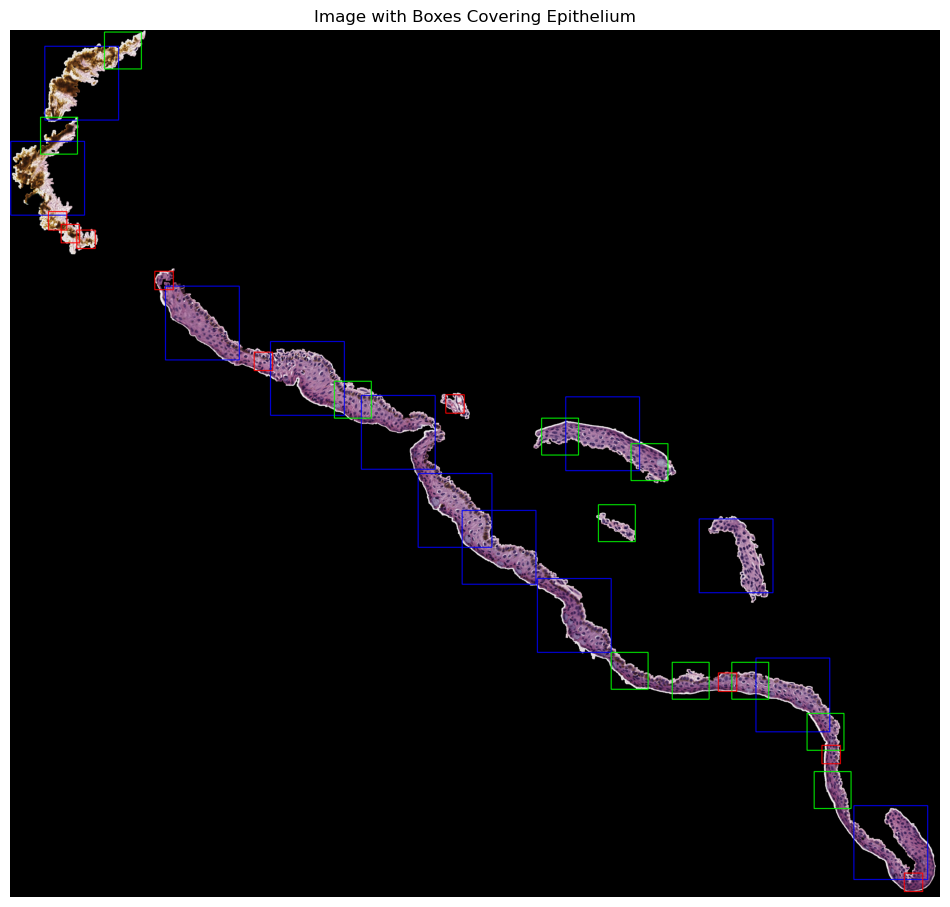

Image saved to D:\390scans\patches\h2114189 h&e_ROI_1 Epithelia.png

Total number of boxes: 136
Number of boxes of size 650x650: 0
Number of boxes of size 520x520: 12
Number of boxes of size 260x260: 11
Number of boxes of size 130x130: 9


In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Replace with your image path
image_path = 'D:\\390scans\\scans\\h2114189 h&e_ROI_1 Epithelia.png'
image = cv2.imread(image_path)

# Mask for the epithelium (non-black pixels)
epithelium_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([255, 255, 255]))

# Box sizes (from largest to smallest), removed the smallest square (80x80)
box_sizes = [650, 520, 260, 130]

# Epithelium coverage thresholds for each box size
epithelium_thresholds = {
    650: 70,
    520: 30,
    260: 20,
    130: 20
}

# Step sizes for the grids (no overlap for all box sizes)
step_sizes = {size: size for size in box_sizes}

# Initialize dictionaries to store boxes of different sizes
boxes = {size: [] for size in box_sizes}
zoomed_in_regions = []
rect_dimensions = []
image_with_rectangles = image.copy()

# Colors for different box sizes (in BGR format)
box_colors = {
    650: (255, 165, 0),  # Orange
    520: (255, 0, 0),    # Blue
    260: (0, 255, 0),    # Green
    130: (0, 0, 255)     # Red
}

# Function to compute overlap percentage between two boxes
def compute_overlap(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    x_left = max(boxA['left'], boxB['left'])
    y_top = max(boxA['top'], boxB['top'])
    x_right = min(boxA['right'], boxB['right'])
    y_bottom = min(boxA['bottom'], boxB['bottom'])

    if x_right <= x_left or y_bottom <= y_top:
        return 0.0  # No overlap

    # Compute the area of overlap
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Compute the area of both rectangles
    areaA = (boxA['right'] - boxA['left']) * (boxA['bottom'] - boxA['top'])
    areaB = (boxB['right'] - boxB['left']) * (boxB['bottom'] - boxB['top'])

    # Compute the overlap percentage relative to both boxes
    overlap_percentage_A = (intersection_area / areaA) * 100
    overlap_percentage_B = (intersection_area / areaB) * 100

    # Return the maximum overlap percentage
    return max(overlap_percentage_A, overlap_percentage_B)

# Start from the top-left corner of the epithelium bounding box
coords = cv2.findNonZero(epithelium_mask)
x, y, w, h = cv2.boundingRect(coords)
start_x = x
start_y = y
end_x = x + w
end_y = y + h

# Initialize the covered mask
covered_mask = np.zeros_like(epithelium_mask)

### Loop over box sizes from largest to smallest ###
for size in box_sizes:
    box_list = boxes[size]
    step_size = step_sizes[size]
    color = box_colors[size]
    required_coverage = epithelium_thresholds[size]
    half_size = size // 2
    separation_threshold = 0.15 * size  # 15% of the box width
    max_shift = half_size  # Maximum shift is half the box size
    shift_step = 10  # Shift step in pixels
    print(f"Placing boxes of size {size}x{size} with at least {required_coverage}% epithelium coverage")

    # Update the remaining epithelium mask
    remaining_epithelium_mask = cv2.bitwise_and(epithelium_mask, cv2.bitwise_not(covered_mask))

    for top in range(start_y, end_y, step_size):
        for left in range(start_x, end_x, step_size):
            best_coverage = 0
            best_shifted_left = None
            best_shifted_top = None

            # Define shift ranges
            shift_range = range(-max_shift, max_shift + 1, shift_step)

            # Search for the shift that captures at least two separate black areas in different regions
            for shift_x in shift_range:
                for shift_y in shift_range:
                    shifted_left = left + shift_x
                    shifted_top = top + shift_y
                    shifted_right = shifted_left + size
                    shifted_bottom = shifted_top + size

                    # Ensure coordinates are within image bounds
                    if shifted_top < 0 or shifted_left < 0 or shifted_bottom > image.shape[0] or shifted_right > image.shape[1]:
                        continue  # Skip positions that go beyond image boundaries

                    # Extract the box region
                    box_region = image[shifted_top:shifted_bottom, shifted_left:shifted_right]
                    box_mask = remaining_epithelium_mask[shifted_top:shifted_bottom, shifted_left:shifted_right]

                    # Calculate the percentage of epithelium pixels in the box
                    total_pixels = box_mask.size  # Total number of pixels in the box
                    epithelium_pixels = cv2.countNonZero(box_mask)
                    epithelium_percentage = (epithelium_pixels / total_pixels) * 100

                    # Proceed only if epithelium coverage meets the required threshold
                    if epithelium_percentage >= required_coverage:
                        # Create a binary mask for black regions within the box
                        black_region_mask = cv2.bitwise_not(box_mask)

                        # Perform connected component analysis on the black regions
                        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(black_region_mask)

                        # Subtract one from num_labels to exclude the background label (0)
                        num_black_regions = num_labels - 1

                        # Proceed only if there are at least two separate black regions
                        if num_black_regions >= 2:
                            # Extract areas of black regions
                            black_areas = [stats[label, cv2.CC_STAT_AREA] for label in range(1, num_labels)]
                            total_black_area = sum(black_areas)

                            # Check that no single black region accounts for more than 70% of total black area
                            largest_black_region_area = max(black_areas)
                            if largest_black_region_area <= 0.7 * total_black_area:
                                # Sort black regions by area
                                sorted_indices = np.argsort(-np.array(black_areas))

                                # Proceed to check the regions where these black regions are mostly located
                                black_region_labels = [sorted_indices[0] + 1, sorted_indices[1] + 1]
                                black_region_regions = []

                                # Define the four regions within the box
                                height, width = black_region_mask.shape
                                half_height = height // 2
                                half_width = width // 2

                                # Create masks for the four regions
                                top_region_mask = np.zeros_like(black_region_mask, dtype=np.uint8)
                                top_region_mask[0:half_height, :] = 1

                                bottom_region_mask = np.zeros_like(black_region_mask, dtype=np.uint8)
                                bottom_region_mask[half_height:, :] = 1

                                left_region_mask = np.zeros_like(black_region_mask, dtype=np.uint8)
                                left_region_mask[:, 0:half_width] = 1

                                right_region_mask = np.zeros_like(black_region_mask, dtype=np.uint8)
                                right_region_mask[:, half_width:] = 1

                                for label in black_region_labels:
                                    region_mask = (labels == label).astype(np.uint8)

                                    # Calculate overlap with each region
                                    top_overlap = cv2.countNonZero(cv2.bitwise_and(region_mask, top_region_mask))
                                    bottom_overlap = cv2.countNonZero(cv2.bitwise_and(region_mask, bottom_region_mask))
                                    left_overlap = cv2.countNonZero(cv2.bitwise_and(region_mask, left_region_mask))
                                    right_overlap = cv2.countNonZero(cv2.bitwise_and(region_mask, right_region_mask))

                                    # Determine which region has the maximum overlap
                                    overlaps = {
                                        'top': top_overlap,
                                        'bottom': bottom_overlap,
                                        'left': left_overlap,
                                        'right': right_overlap
                                    }
                                    max_region = max(overlaps, key=overlaps.get)
                                    black_region_regions.append(max_region)

                                # Check if the two largest black regions are mostly in different regions
                                if black_region_regions[0] != black_region_regions[1]:
                                    # Update best coverage and position
                                    if epithelium_percentage > best_coverage:
                                        best_coverage = epithelium_percentage
                                        best_shifted_left = shifted_left
                                        best_shifted_top = shifted_top
                                        best_box_region = box_region
                                        best_box_mask = box_mask
                                        best_epithelium_pixels = epithelium_pixels
                                        best_black_areas = black_areas  # Save black areas for later use
                                        best_total_black_area = total_black_area
                                        best_largest_black_region_area = largest_black_region_area

            # After searching all shifts, proceed with the best position
            if best_coverage >= required_coverage and best_shifted_left is not None:
                # Ensure the largest black region does not exceed 70% of total black area
                if best_largest_black_region_area <= 0.7 * best_total_black_area:
                    # Create a dictionary for the current box
                    current_box = {'left': best_shifted_left, 'top': best_shifted_top, 'right': best_shifted_left + size, 'bottom': best_shifted_top + size}

                    # Check for overlap with existing boxes of all sizes
                    overlap_found = False
                    for other_size in box_sizes:
                        # Skip if there are no boxes of this size yet
                        if not boxes[other_size]:
                            continue
                        for existing_box in boxes[other_size]:
                            overlap_percentage = compute_overlap(current_box, existing_box)
                            if overlap_percentage > 35:
                                overlap_found = True
                                break  # No need to check further
                        if overlap_found:
                            break  # No need to check other sizes

                    if not overlap_found:
                        # Store the box information
                        box_list.append(current_box)
                        zoomed_in_regions.append(best_box_region)
                        rect_dimensions.append((size, size))

                        # Draw the box on the image
                        thickness = 6
                        cv2.rectangle(image_with_rectangles, (best_shifted_left, best_shifted_top), (best_shifted_left + size, best_shifted_top + size), color, thickness=thickness)
                    else:
                        # Skip this box due to overlap
                        continue
                else:
                    # Largest black region exceeds 70% of total black area; skip this box
                    continue

# Display the original image with all rectangles
plt.figure(figsize=(12, 12))
plt.title("Image with Boxes Covering Epithelium")
plt.imshow(cv2.cvtColor(image_with_rectangles, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

output_path = 'D:\\390scans\\patches\\h2114189 h&e_ROI_1 Epithelia.png' 
cv2.imwrite(output_path, image_with_rectangles)
print(f"Image saved to {output_path}")

# # Display zoomed-in regions
# num_boxes = len(zoomed_in_regions)
# if num_boxes > 0:
#     plt.figure(figsize=(15, 15))
#     cols = min(5, num_boxes)
#     rows = (num_boxes + cols - 1) // cols
#     for i, region in enumerate(zoomed_in_regions, 1):
#         plt.subplot(rows, cols, i)
#         plt.title(f"Box {i}")
#         plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
#         plt.axis("off")
#     plt.tight_layout()
#     plt.show()
# else:
#     print("No boxes to display.")

# Print dimensions of each box and calculate total area
# total_area = 0
# for i, (width, height) in enumerate(rect_dimensions, 1):
#     area = width * height
#     total_area += area
#     print(f"Box {i} dimensions: Width = {width} pixels, Height = {height} pixels, Area = {area} pixels^2")

# Print the total number of boxes and the number of boxes of each size
print(f"\nTotal number of boxes: {num_boxes}")
for size in box_sizes:
    print(f"Number of boxes of size {size}x{size}: {len(boxes[size])}")

# # Print the total area of all boxes
# print(f"\nTotal area of all boxes: {total_area} pixels^2")
